<a href="https://colab.research.google.com/github/javmencia/RBLog/blob/main/RegressionModelv19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import arviz as az

import pymc as pm
import pytensor.tensor as pt

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats
import time
import math
from matplotlib import cm


def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

In [2]:
n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
# X = np.random.normal(size=(n, p))
X = np.ones((n, p))
X[:int(n/2),0] = 0
X[0:-1:2,1] = 0

# Ground truth parameters for generating data
# beta0 = np.array([1, 2])
print(X)
β_true = np.logspace(0, 1, 2,base=2)
σ_true = 1
print(β_true)
mu0 = np.dot(X, β_true)

# Generate response variable y
# y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
np.random.seed(135)
y = X@β_true + stats.norm(0,σ_true).rvs(n)
β_true,X,y # print("y", y)

[[0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]]
[1. 2.]


(array([1., 2.]),
 array([[0., 0.],
        [0., 1.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.]]),
 array([-1.26485598,  3.18428092,  0.35504683,  1.70205735, -0.53348411,
         3.43950814,  1.54291277,  3.0241124 ,  0.07233906,  2.68438127]))

# Bias Against

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1


# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=beta0, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.InverseGamma("sigma", alpha=3, beta=2)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    y_ = pm.MvNormal('y_', mu=mu, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pdl = pm.Deterministic(f'prior_pdl', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y)) + np.dot(Sigma_beta_inv, beta0))
    mean_beta = pm.Deterministic('mean_beta', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, y_)) + np.dot(Sigma_beta_inv, beta0)))
    β_post_CholeskyLower = np.linalg.cholesky(cov_beta_post)
    # Posterior distribution for beta at each point
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_beta, chol=β_post_CholeskyLower, shape=p), beta))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pdl)

    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), y_).sum())
    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-40-30211727bcd2>:24: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


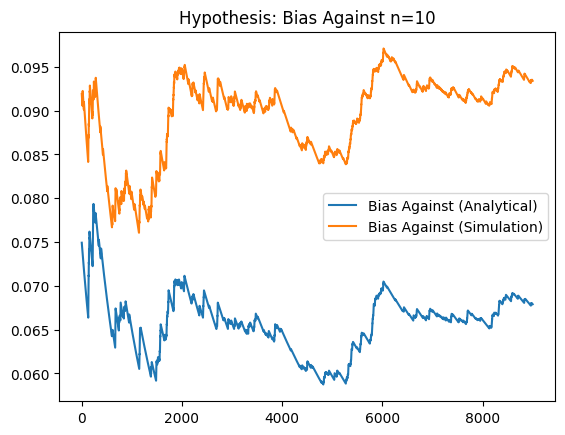

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logBR_prior_pdl"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pdl'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

Bias In Favor

Prior:
\begin{align*}
p(\boldsymbol \beta) = {}& \mathcal{MVN}\left(E[\boldsymbol \beta ] = \boldsymbol \beta_0, \text{Cov}[\boldsymbol \beta ] = \boldsymbol \Sigma_\beta \right) \quad \\
p(\boldsymbol \sigma ^2) = {}& \mathcal{InverseGamma}\left(\boldsymbol \alpha = 3, \beta = 2 \right) \quad
\end{align*}

Posterior:
\begin{align*}
p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y^*}) = {}& \mathcal{MVN}\left(\overset{E[\boldsymbol \beta^* | \boldsymbol\Sigma, \mathbf{X},\mathbf{y^*}] \; = \quad\quad}{\text{Cov}[\boldsymbol \beta ^* | \boldsymbol\Sigma, \mathbf{X},\mathbf{y^*}]}\bigg( \mathbf{X}^\top \boldsymbol\Sigma^{-1}\mathbf{y^*} + \boldsymbol \Sigma_\beta^{-1}\boldsymbol\beta^* \right), \text{Cov}[\boldsymbol \beta ^* | \boldsymbol\Sigma, \mathbf{X},\mathbf{y^*}] = \left[\mathbf{X}^{\top}\boldsymbol \Sigma^{-1} \mathbf{X}  + \boldsymbol \Sigma_\beta^{-1} \right]^{-1} \bigg)\\
\end{align*}

Y:
\begin{align*}\require{cancel}
\mathbf{y}_{n\times 1} \sim {} & \mathcal{MVN}(\mathbf{X}_{n\times p}\boldsymbol{\beta}_{p\times 1},\boldsymbol \Sigma_{n\times n} = \sigma^2I_{n\times n})\\
\end{align*}

In [9]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(sigma0**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(sigma0**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-10-275779955501>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()


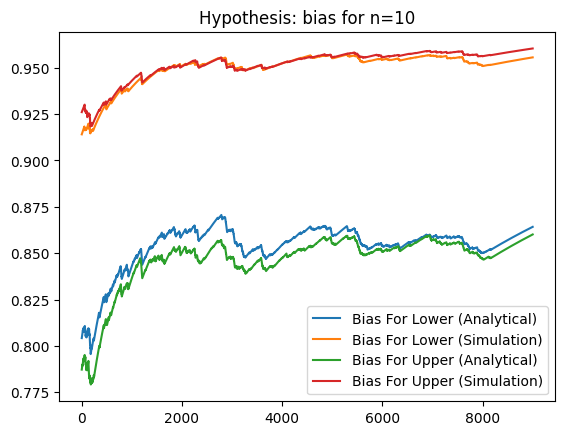

In [10]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [22]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(sigma0**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(sigma0**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-23-275779955501>:25: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
<ipython-input-23-275779955501>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()


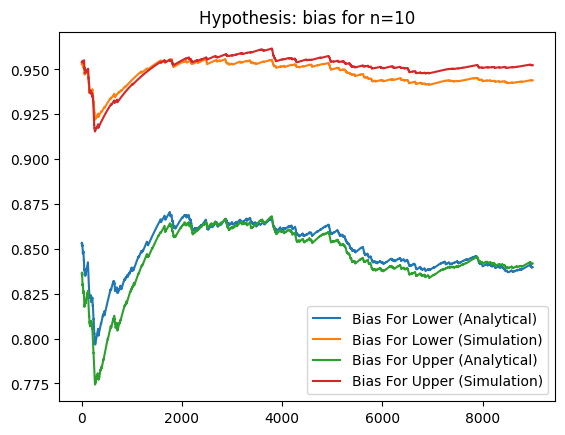

In [23]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


Shapes

In [ ]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2

# Ground truth parameters for generating data
beta0 = β_true
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 25  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

num_points = len(circle_points)

# Vectorized response variable generation
muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu =X@beta
    # Prior for beta at each point
    prior_pd = pm.Deterministic('prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points):
        # Likelihood
        mu_l = np.dot(X, betal)
        yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma**2) * np.eye(n), shape=n)

        #Lower
        mean_betal = pm.Deterministic(f'mean_betal_{i}', cov_beta_post @(X.T@yl_ + betal/(sigma0**2)))
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())


    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")



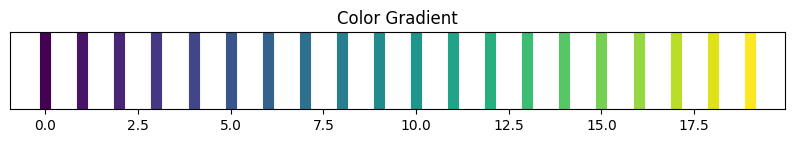

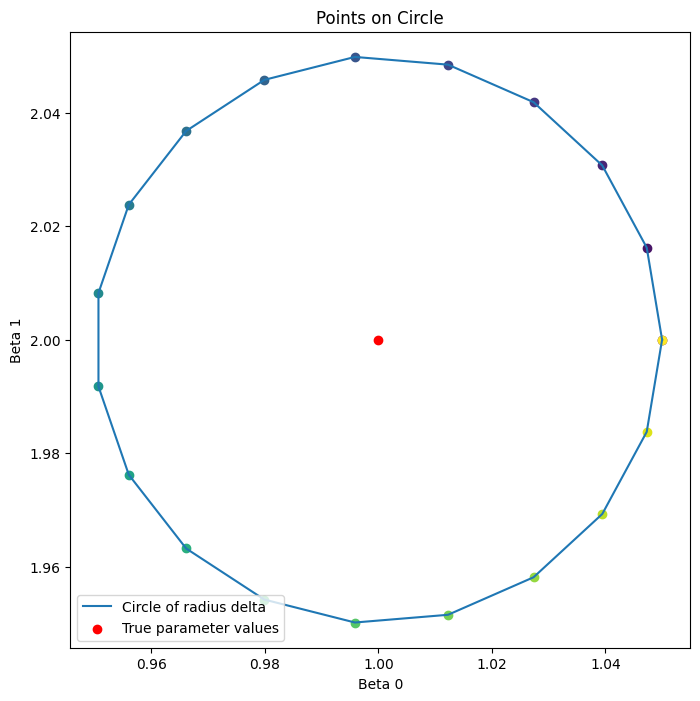

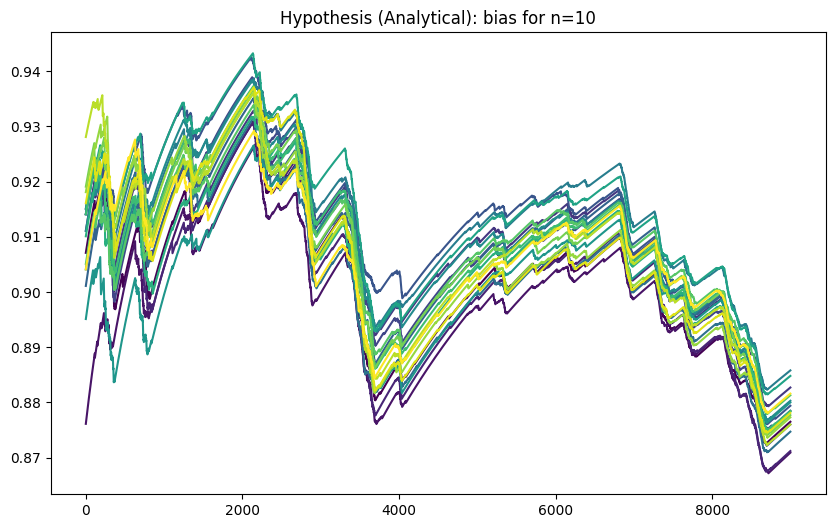

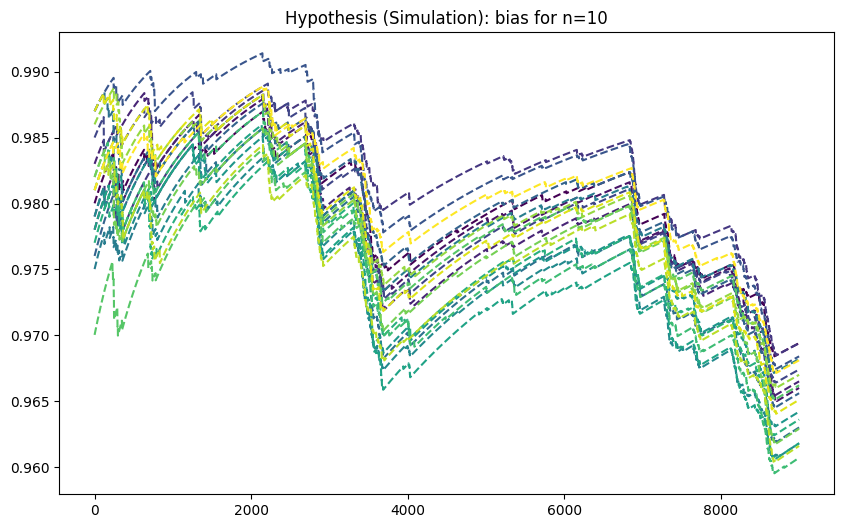

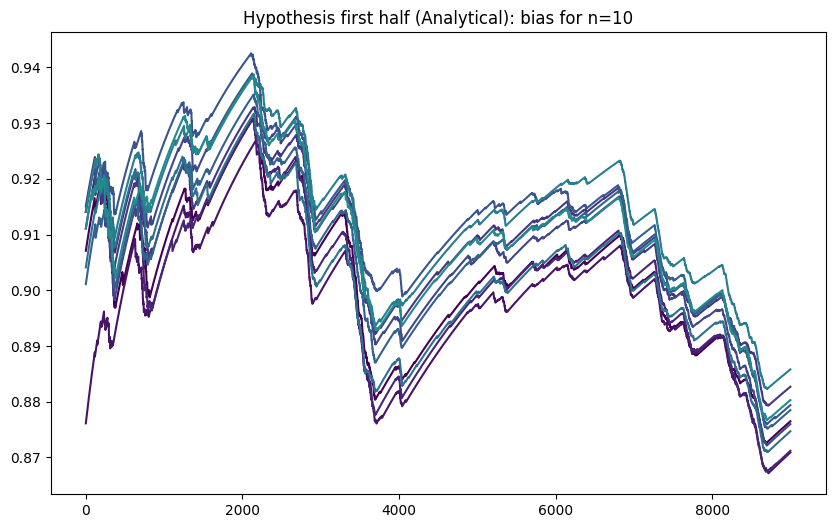

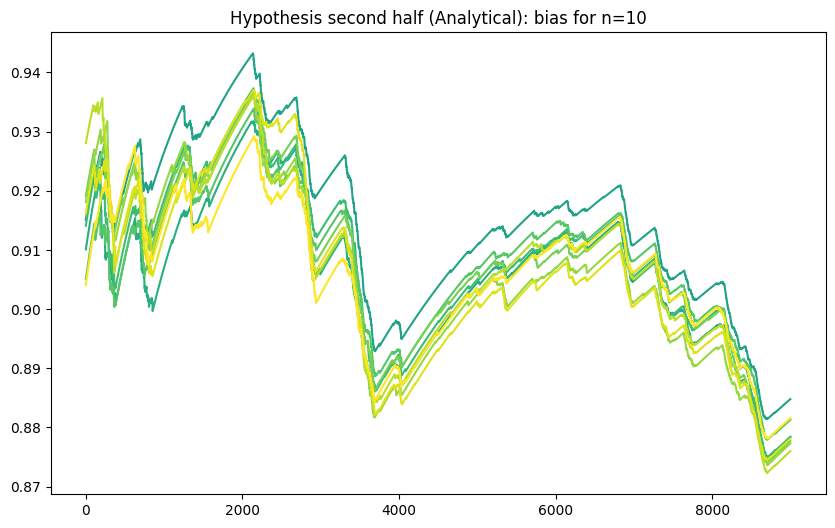

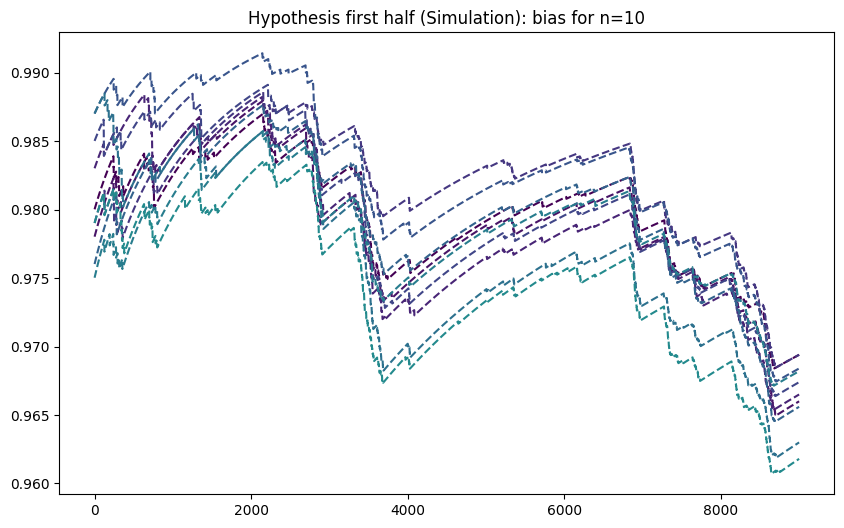

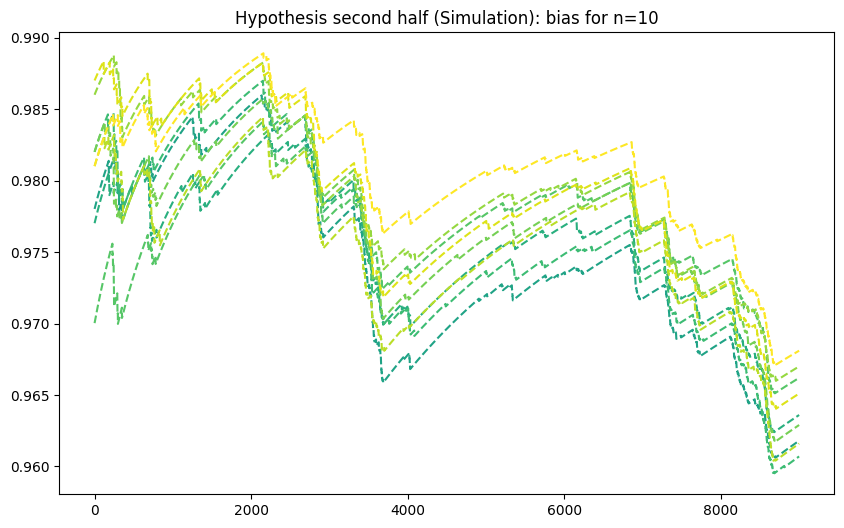

In [5]:
# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'yl_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
# Generate points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Circle of radius delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

# Plotting the points with corresponding colors
circle_points = np.column_stack((x, y))
for idx in range(num_points):
    plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

Different deltas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

# Function to calculate Bezier curve points
def bezier_curve(control_points, num_points=100):
    n = len(control_points) - 1
    curve = np.zeros((num_points, 2))
    t = np.linspace(0, 1, num_points)
    for i in range(n + 1):
        curve += np.outer(binom(n, i) * (t ** i) * ((1 - t) ** (n - i)), control_points[i])
    return curve

# True parameter values
beta0 = np.array([1, 2])
delta0 = 0.05  # Half-diagonal length of the rhombus
delta1 = 0.15
# Define the four vertices of the rhombus
vertices = np.array([
    [beta0[0] + delta0, beta0[1]],  # Right vertex
    [beta0[0], beta0[1] + delta1],  # Top vertex
    [beta0[0] - delta0, beta0[1]],  # Left vertex
    [beta0[0], beta0[1] - delta1]   # Bottom vertex
])

# Define control points for inward-curving sides
control_points = []
control_points.append([vertices[1], beta0, vertices[2]])  # Top to Left
control_points.append([vertices[2], beta0, vertices[3]])  # Left to Bottom
control_points.append([vertices[3], beta0, vertices[0]])  # Bottom to Right
control_points.append([vertices[0], beta0, vertices[1]])  # Right to Top

# Generate points on the inward-curving rhombus
num_points_per_curve = 5
curved_points = []
for cp in control_points:
    curve = bezier_curve(cp, num_points_per_curve)
    curved_points.append(curve)

# Concatenate all points
curved_rhombus_points = np.vstack(curved_points)


In [7]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1


# Ground truth parameters for generating data
mu0 = np.dot(X, beta0)
sigma0 = 1

num_points = len(curved_rhombus_points)

# Vectorized response variable generation
muls = np.dot(X, curved_rhombus_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu =X@beta
    # Prior for beta at each point
    prior_pd = pm.Deterministic('prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Iterate over each point on the circle
    for i, betal in enumerate(curved_rhombus_points):
        # Likelihood
        mu_l = np.dot(X, betal)
        yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma**2) * np.eye(n), shape=n)

        #Lower
        mean_betal = pm.Deterministic(f'mean_betal_{i}', cov_beta_post @(X.T@yl_ + betal/(sigma0**2)))
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())


    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")



Cell execution time: 1034.51 seconds


[ -4.72251946  -4.74470685   0.40542405 ... -27.96665375 -27.96665375
 -24.87562189]
[ -6.56039652  -6.58258391  -1.43245302 ... -29.80453081 -29.80453081
 -26.71349896]


<ipython-input-8-71a473b265a1>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


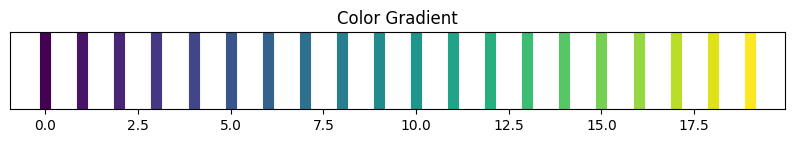

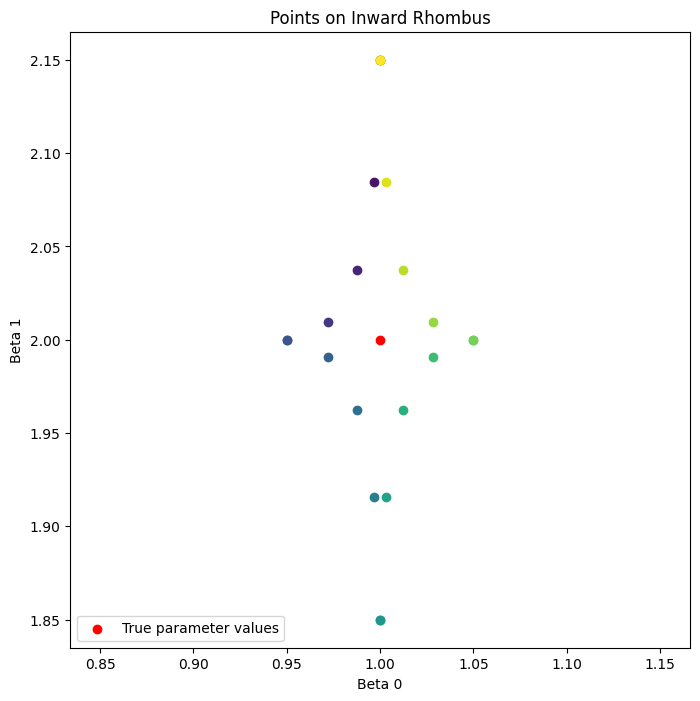

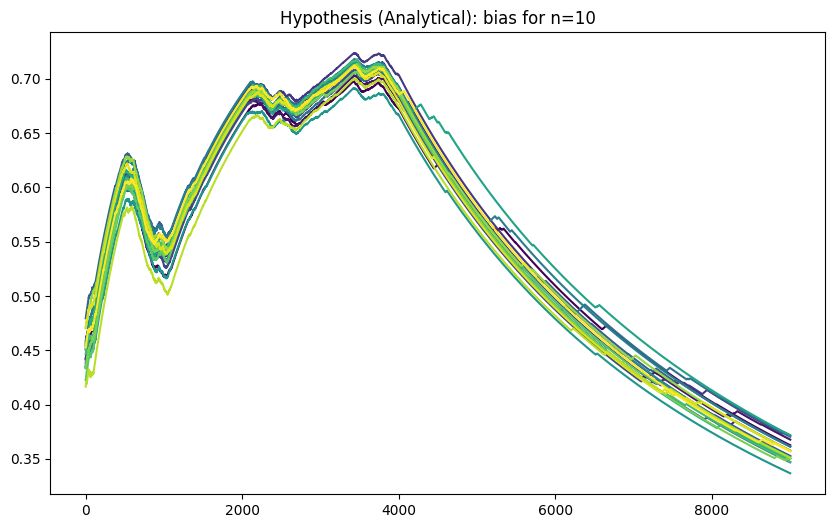

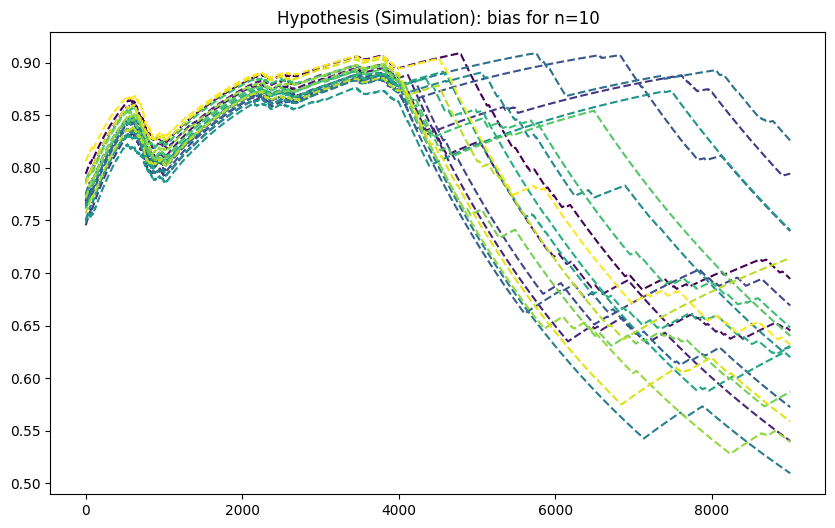

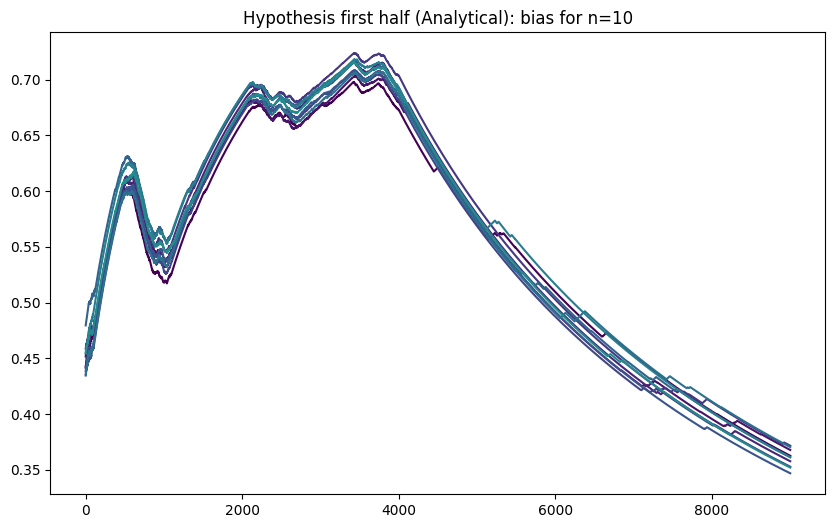

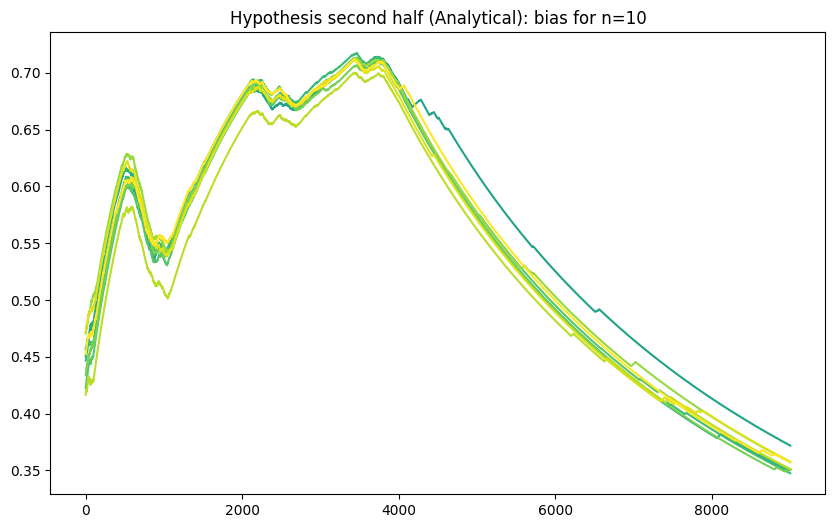

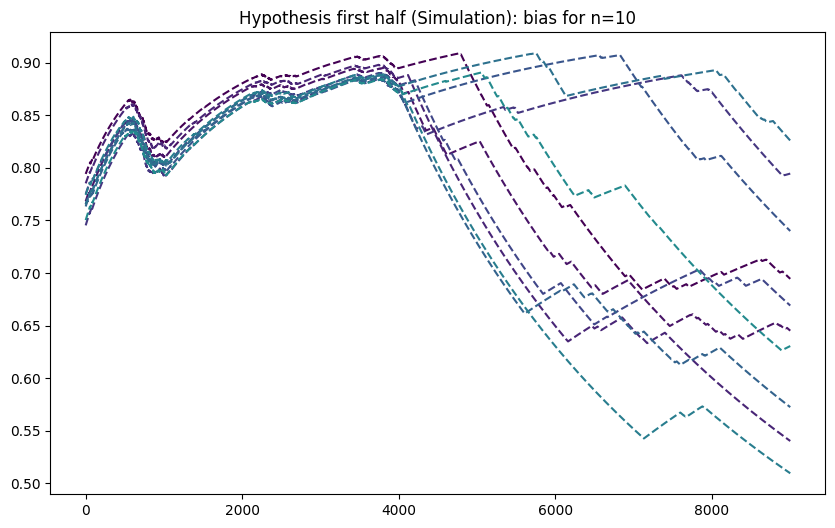

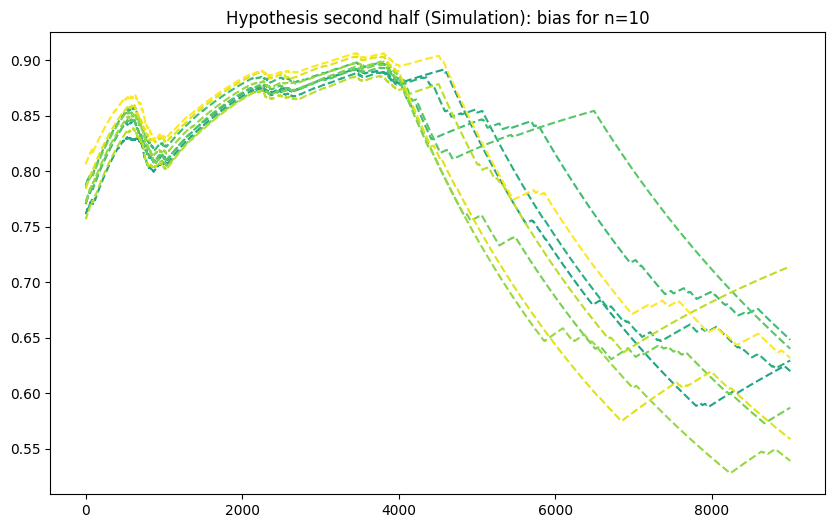

In [8]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)




# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    if idx == 0:
        print(idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'posterior_pdl_{idx}'].values.ravel())

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'yl_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')


for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

Comparing different deltas

In [32]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2

# Ground truth parameters for generating data
beta0 = β_true
mu0 = np.dot(X, beta0)
deltas = [0.05, 0.10, 0.25, 0.5]
sigma0 = 1

biasfortotal = []
biasformltotal = []

for delta in deltas:
    # Generate points on the circle
    num_points = 10  # Number of points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))
    num_points = len(circle_points)

    # Vectorized response variable generation
    muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
    yls = muls + np.random.normal(0, sigma0, (num_points, n))

    # Posterior calculations
    cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
    β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

    start_time = time.time()

    with pm.Model() as model:
        # Priors
        beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
        sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
        mu =X@beta
        # Prior for beta at each point
        prior_pd = pm.Deterministic('prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

        # Iterate over each point on the circle
        for i, betal in enumerate(circle_points):
            # Likelihood
            mu_l = np.dot(X, betal)
            yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma**2) * np.eye(n), shape=n)

            #Lower
            mean_betal = pm.Deterministic(f'mean_betal_{i}', cov_beta_post @(X.T@yl_ + betal/(sigma0**2)))
            posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

            # Log BR
            logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


            # Likelihood
            likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())


        # Sampling
        idata = pm.sample(draws=5000, tune=1000)

    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    print(f"Cell execution time: {elapsed_time:.2f} seconds")
    # Compute biases for all points on the circle
    bias_for = []
    bias_for_ml = []
    urn = 1000
    for idx in range(num_points):

        logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
        likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

        bias_for_values = logBR_prior_pd_values > 0
        bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

        mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
        y_samples = idata.posterior[f'yl_{idx}'].values
        marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
        log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

        bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
        bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

        bias_for.append(bias_for_mci)
        bias_for_ml.append(bias_for_ml_mci)
    biasfortotal.append(bias_for)
    biasformltotal.append(bias_for_ml)


Cell execution time: 1004.62 seconds


<ipython-input-32-f31c70bbe48d>:84: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


Cell execution time: 515.66 seconds


Cell execution time: 924.57 seconds


Cell execution time: 785.19 seconds


<ipython-input-32-f31c70bbe48d>:84: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


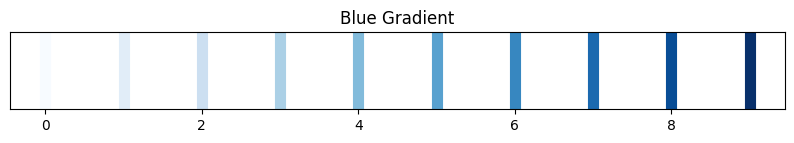

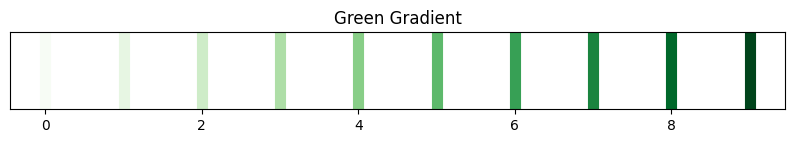

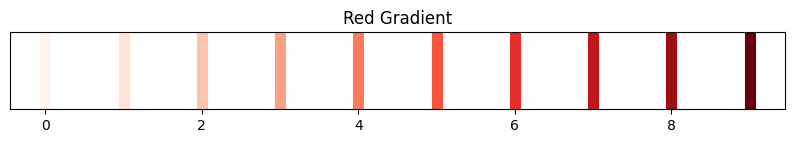

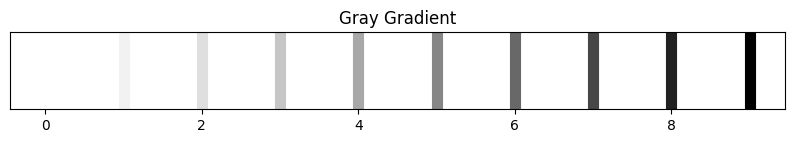

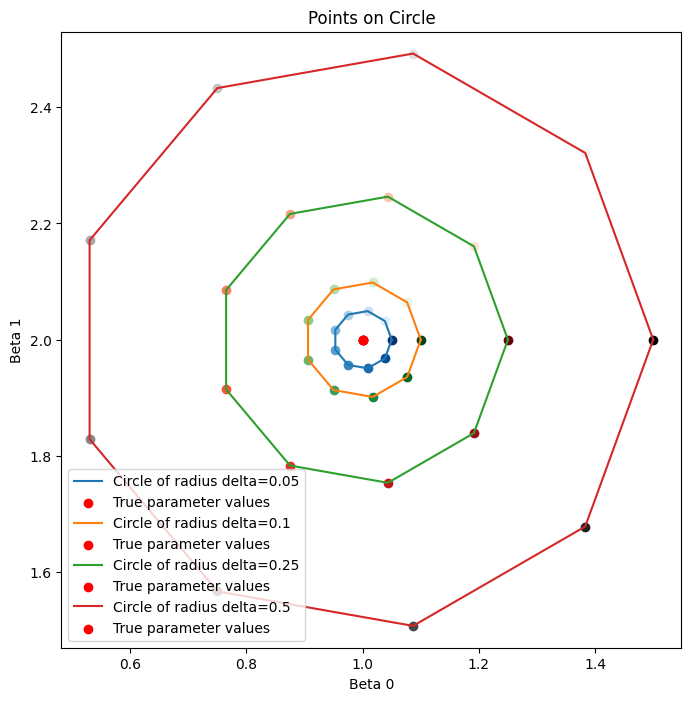

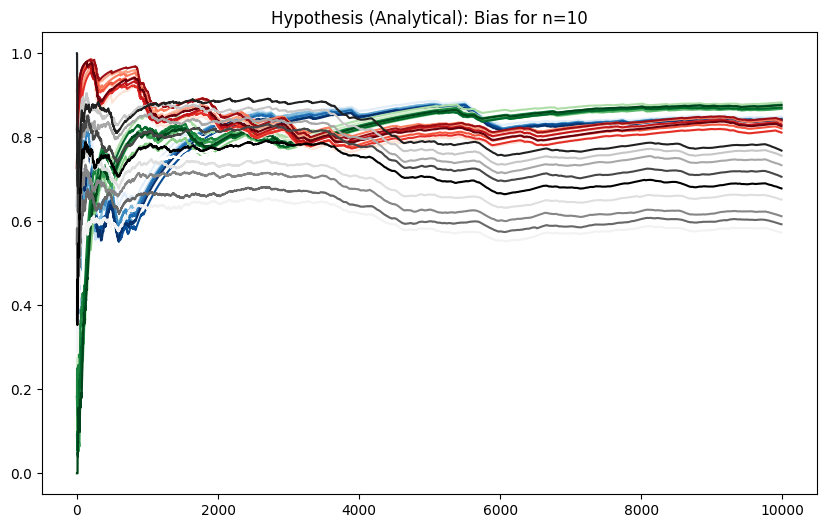

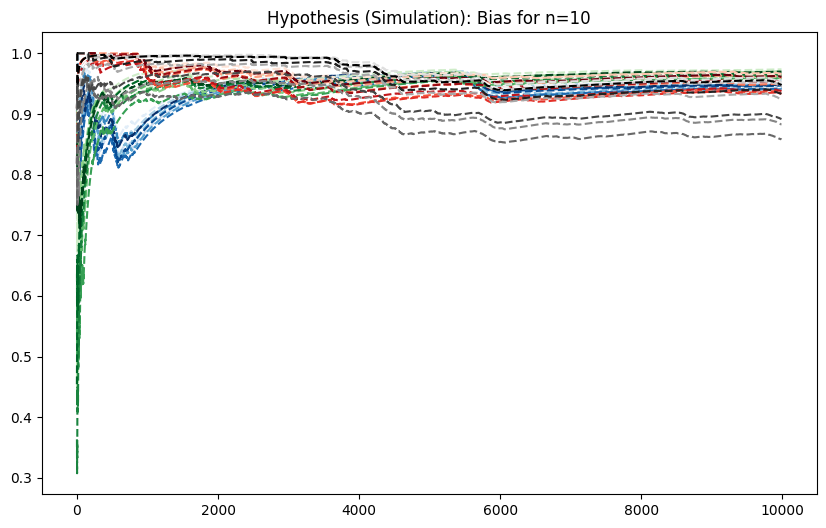

In [33]:
# Generate colors from colormaps
colors_blue = cm.Blues(np.linspace(0, 1, num_points))
colors_green = cm.Greens(np.linspace(0, 1, num_points))
colors_red = cm.Reds(np.linspace(0, 1, num_points))
colors_greys = cm.Greys(np.linspace(0, 1, num_points))


# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors_blue):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Blue Gradient")
plt.yticks([])
plt.show()

plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors_green):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Green Gradient")
plt.yticks([])
plt.show()

plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors_red):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Red Gradient")
plt.yticks([])
plt.show()

plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors_greys):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Gray Gradient")
plt.yticks([])
plt.show()

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))

# Plot each delta with its color gradient
for i, delta in enumerate(deltas):
    if i == 0:
        colors = colors_blue
    elif i == 1:
        colors = colors_green
    elif i==2:
        colors = colors_red
    else:
        colors = colors_greys
    # Generate points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = beta0[0] + delta * np.cos(theta)
    y = beta0[1] + delta * np.sin(theta)
    plt.plot(x, y, label=f'Circle of radius delta={delta}')
    plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

    # Plotting the points with corresponding colors
    circle_points = np.column_stack((x, y))
    for idx in range(num_points):
        plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

# Plotting Hypothesis (Analytical): Bias For
plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    if i == 0:
        colors = colors_blue
    elif i == 1:
        colors = colors_green
    elif i==2:
        colors = colors_red
    else:
        colors = colors_greys

    for idx in range(num_points):
        plt.plot(biasfortotal[i][idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])

plt.title("Hypothesis (Analytical): Bias for n={}".format(n))
plt.show()

# Plotting Hypothesis (Simulation): Bias For
plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    if i == 0:
        colors = colors_blue
    elif i == 1:
        colors = colors_green
    elif i==2:
        colors = colors_red
    else:
        colors = colors_greys

    for idx in range(num_points):
        plt.plot(biasformltotal[i][idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])


plt.title("Hypothesis (Simulation): Bias for n={}".format(n))
plt.show()



Previous work

In [ ]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2

# Ground truth parameters for generating data
beta0 = β_true
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 15  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

num_points = len(circle_points)

# Vectorized response variable generation
muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu =X@beta
    # Prior for beta at each point
    prior_pd = pm.Deterministic('prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points):
        # Likelihood
        mu_l = np.dot(X, betal)
        yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma**2) * np.eye(n), shape=n)



        #Lower
        mean_betal = pm.Deterministic(f'mean_betal_{i}', cov_beta_post @(X.T@yl_ + betal/(sigma**2)))
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yl_).sum())


    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")



Cell execution time: 1362.29 seconds


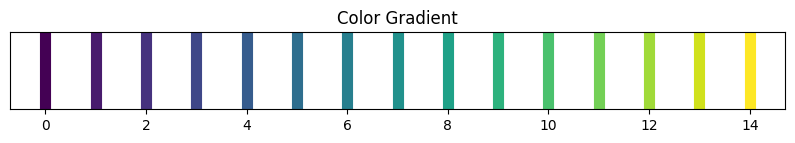

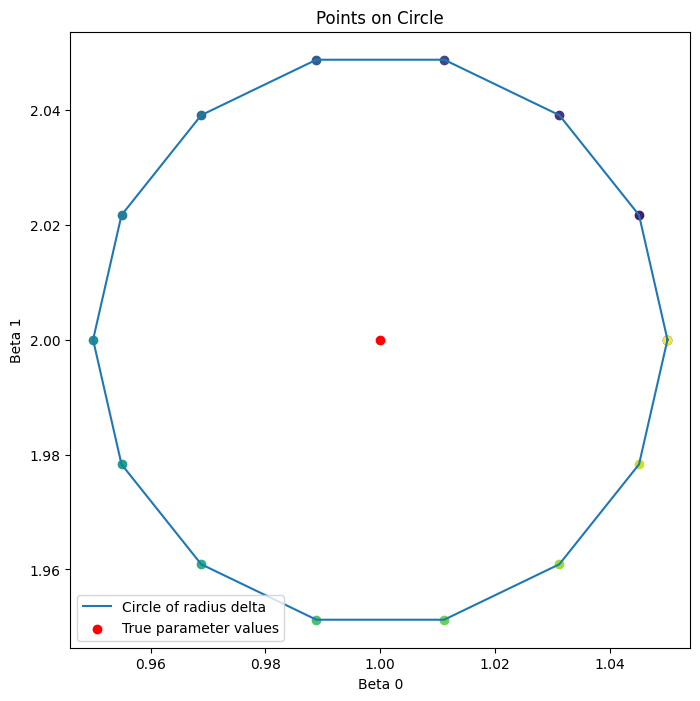

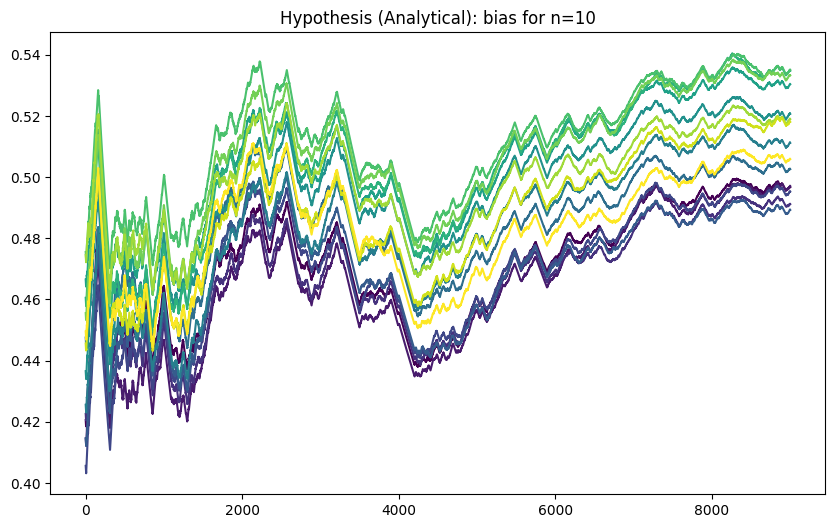

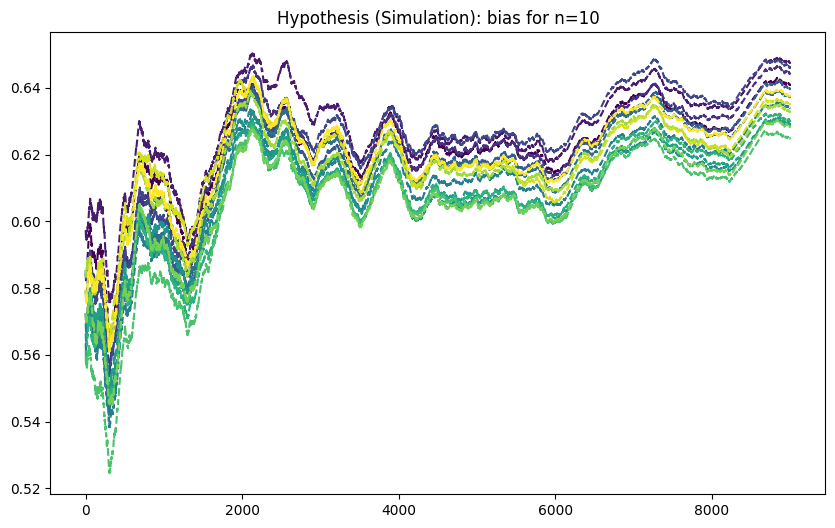

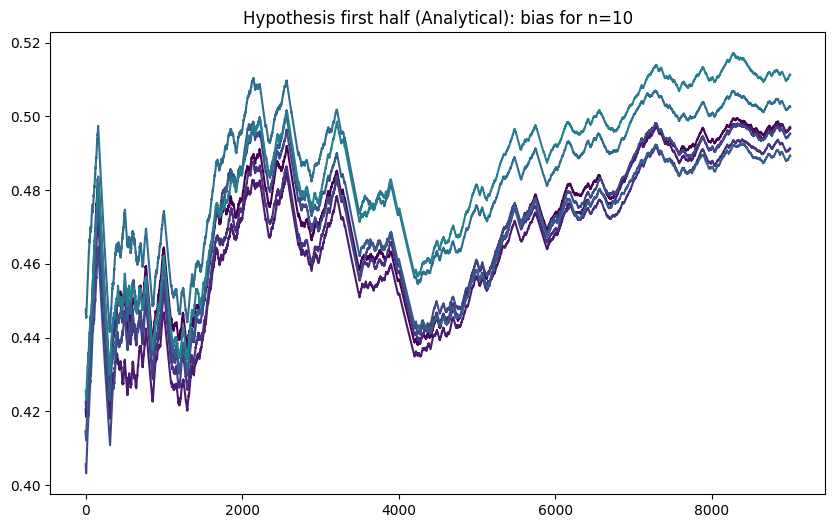

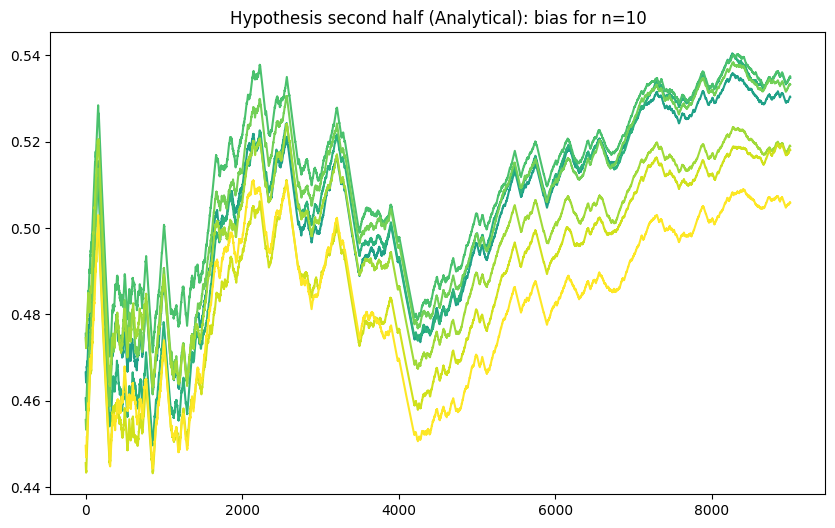

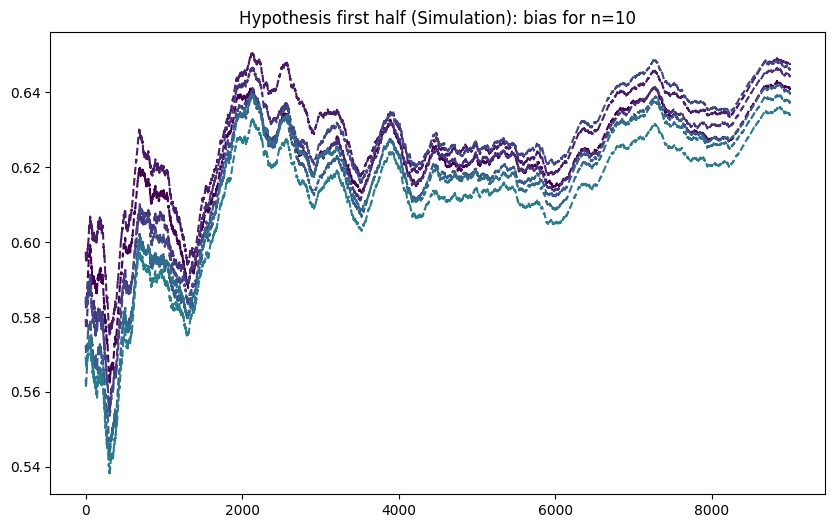

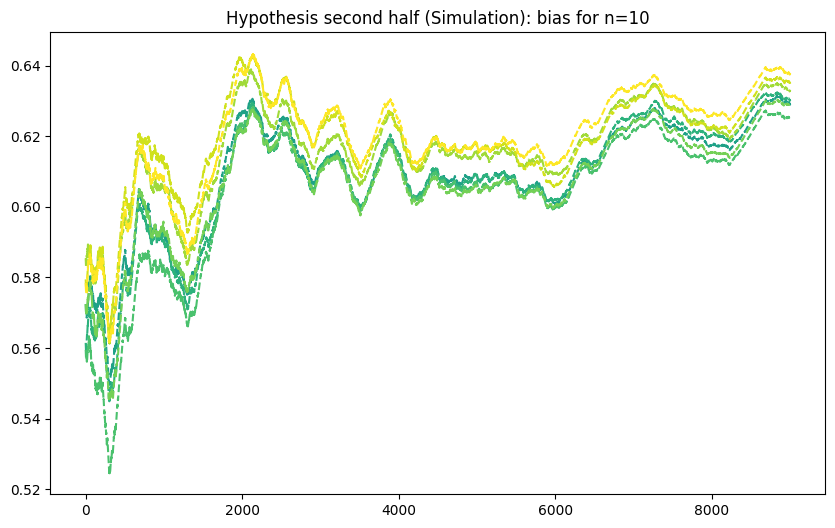

In [ ]:
# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'yl_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
# Generate points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Circle of radius delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

# Plotting the points with corresponding colors
circle_points = np.column_stack((x, y))
for idx in range(num_points):
    plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

In [ ]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2

# Ground truth parameters for generating data
beta0 = β_true
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 10  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

num_points = len(circle_points)

# Vectorized response variable generation
muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu =X@beta
    # Prior for beta at each point
    prior_pd = pm.Deterministic('prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points):
        # Likelihood
        mu_l = np.dot(X, betal)
        yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma**2) * np.eye(n), shape=n)

        #Lower
        mean_betal = pm.Deterministic(f'mean_betal_{i}', cov_beta_post @(X.T@yl_ + betal/(sigma0**2)))
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())


    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")



Different deltas

[ 0.96011902 -0.14157904 -0.98060644 ...  0.35607932  0.75865862
  0.78529551]
[-0.87775805 -1.97945611 -2.81848351 ... -1.48179774 -1.07921844
 -1.05258156]


<ipython-input-39-71a473b265a1>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


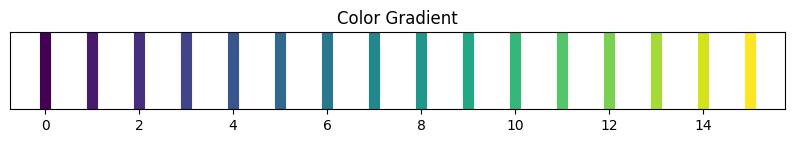

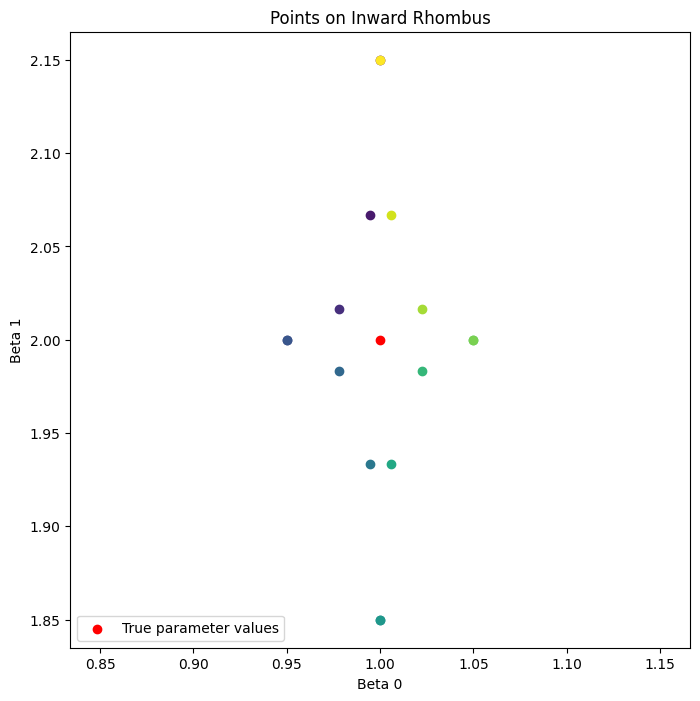

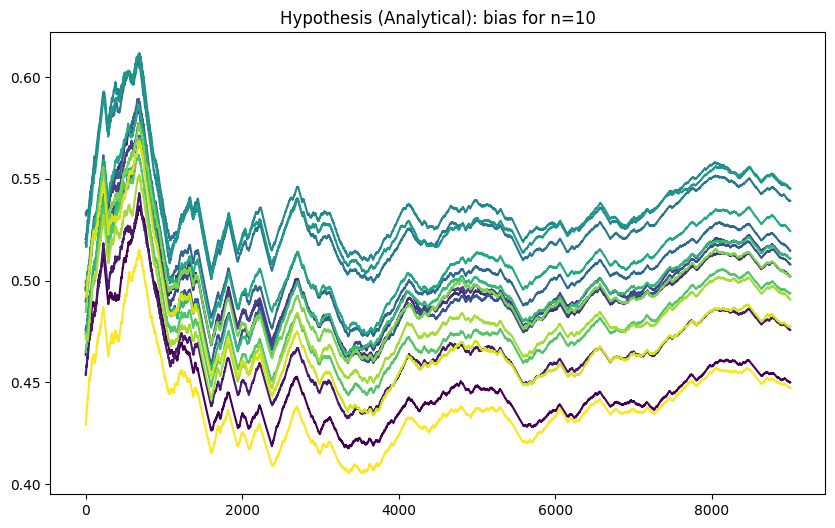

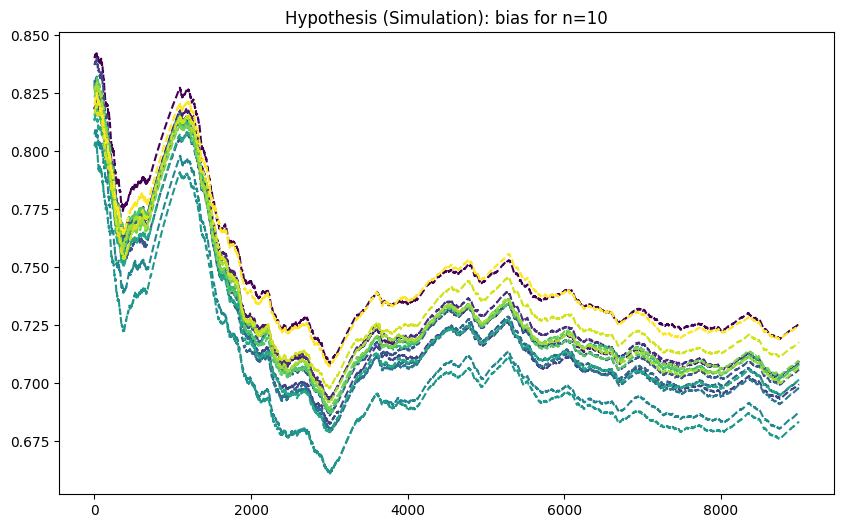

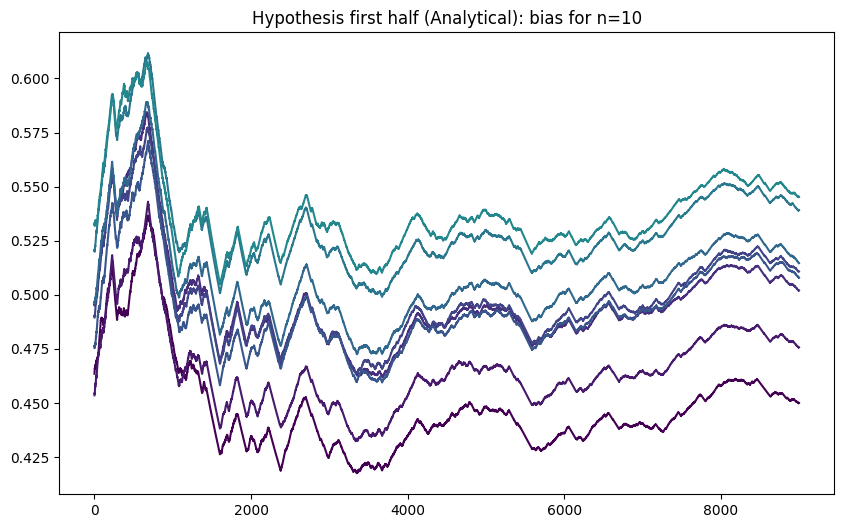

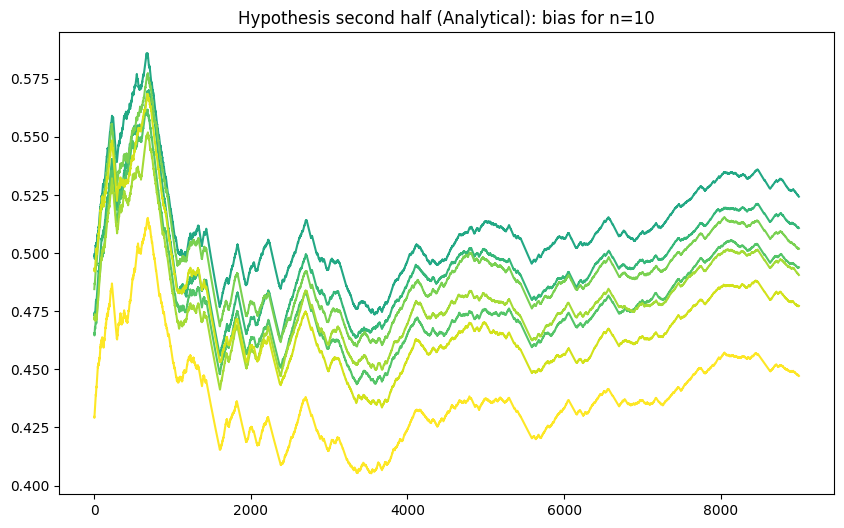

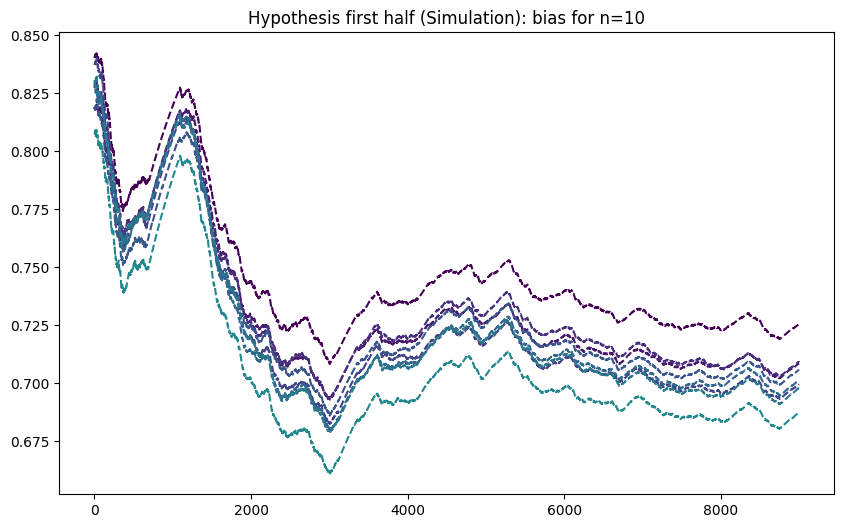

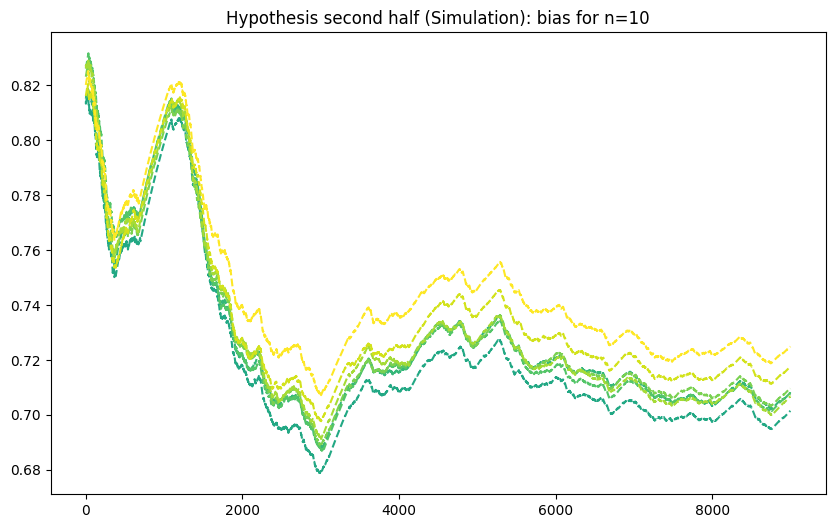

In [39]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)




# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    if idx == 0:
        print(idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'posterior_pdl_{idx}'].values.ravel())

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'yl_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')


for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

[-4.6429765  -0.17715891 -2.85110441 ...  1.02446473  1.16582252
  1.17661458]
[-6.48085357 -2.01503597 -4.68898147 ... -0.81341233 -0.67205455
 -0.66126249]


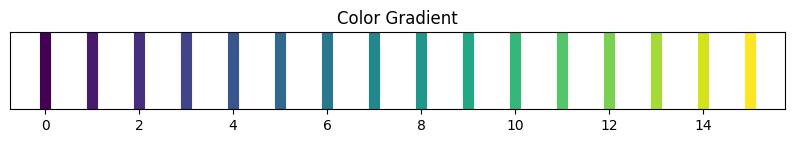

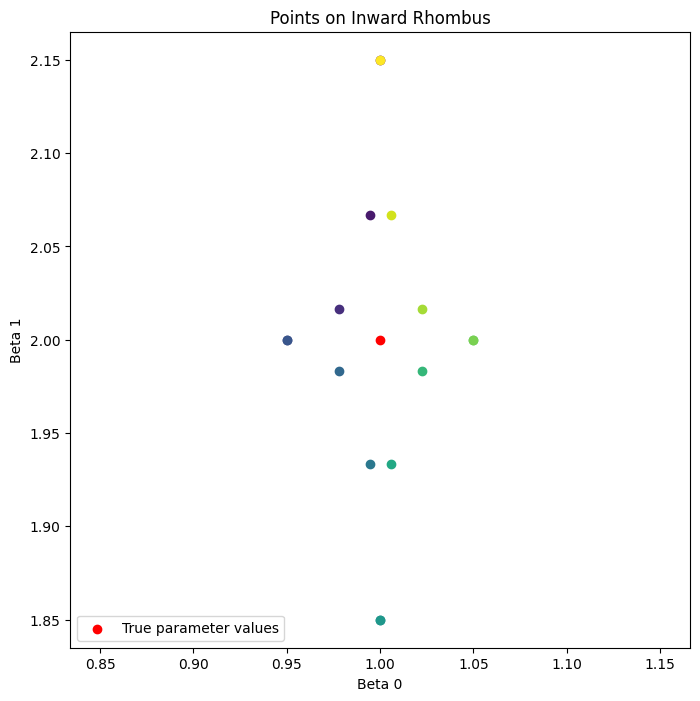

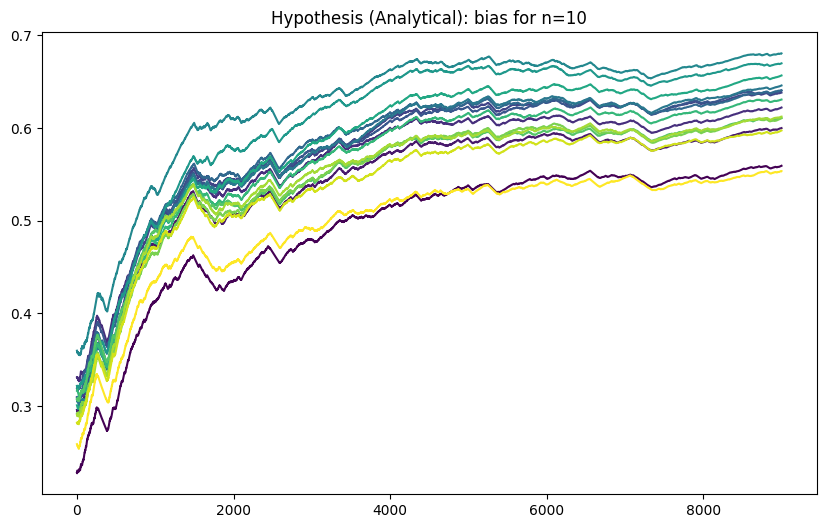

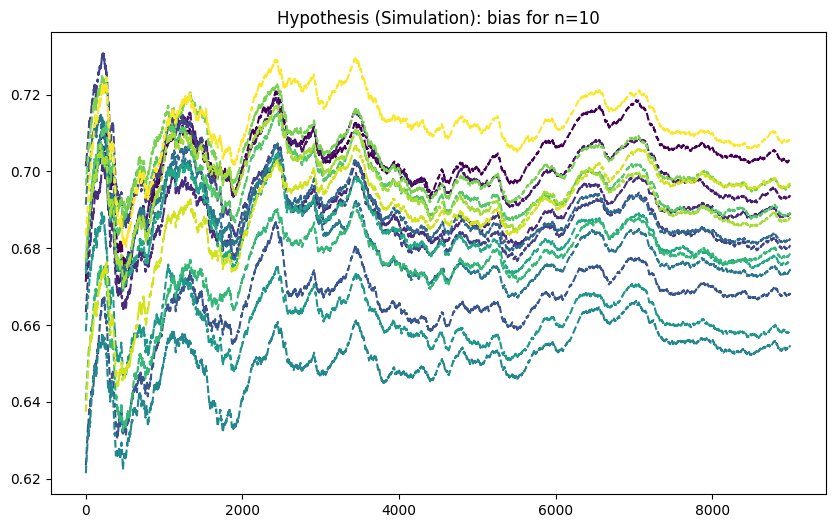

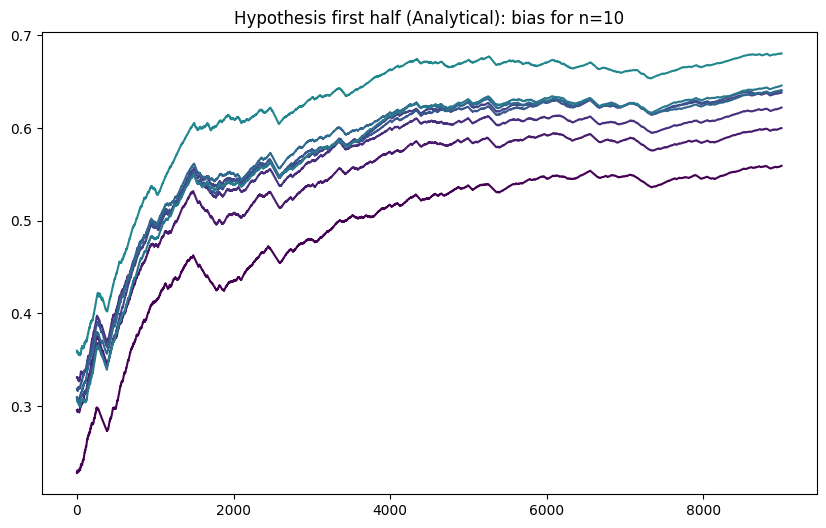

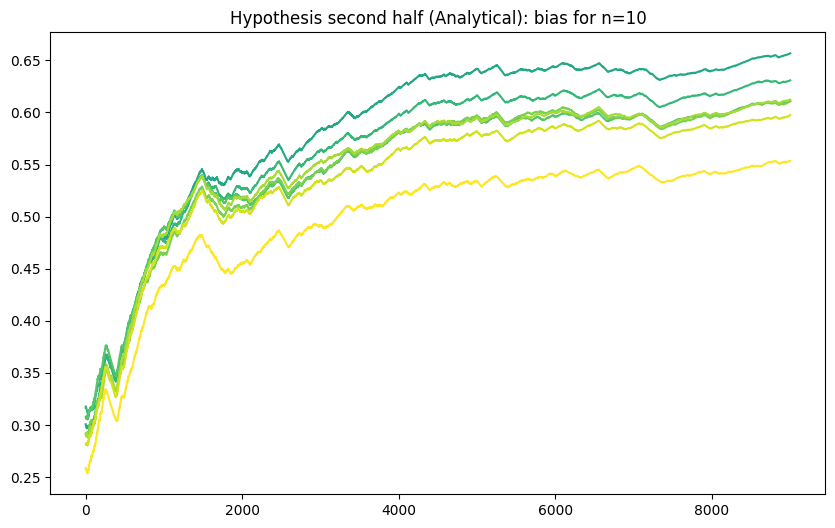

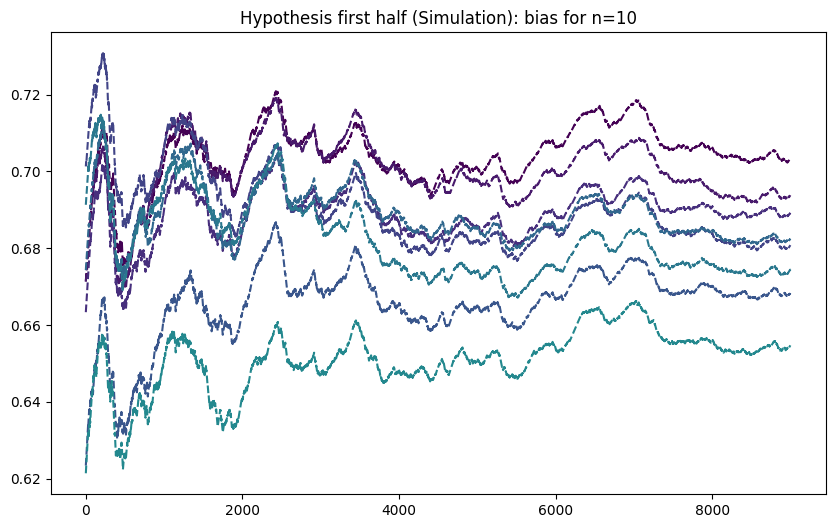

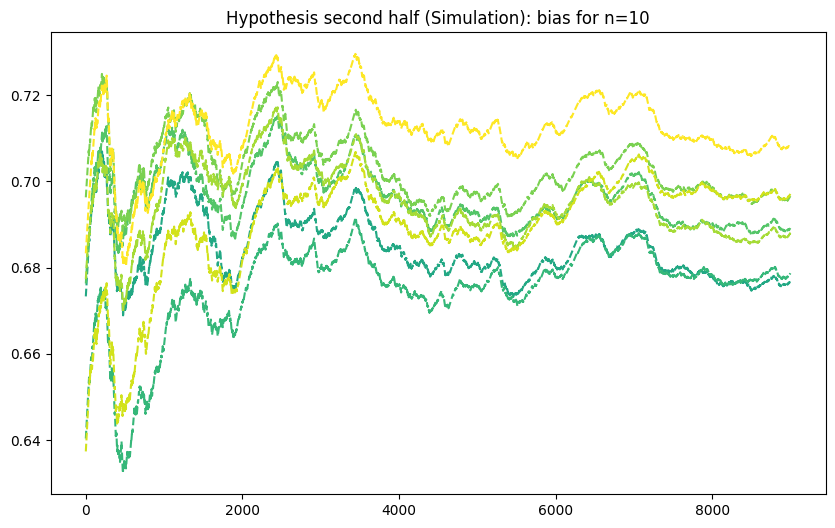

In [28]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)




# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    if idx == 0:
        print(idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'posterior_pdl_{idx}'].values.ravel())

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'yl_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')


for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

In [ ]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2

# Ground truth parameters for generating data
beta0 = β_true
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 30  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

num_points = len(circle_points)

# Vectorized response variable generation
muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu =X@beta
    # Prior for beta at each point
    prior_pd = pm.Deterministic('prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points):
        # Likelihood
        mu_l = np.dot(X, betal)
        yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma**2) * np.eye(n), shape=n)



        #Lower
        mean_betal = pm.Deterministic(f'mean_betal_{i}', cov_beta_post @(X.T@yl_ + betal/(sigma**2)))
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yl_).sum())


    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")



Cell execution time: 2280.14 seconds


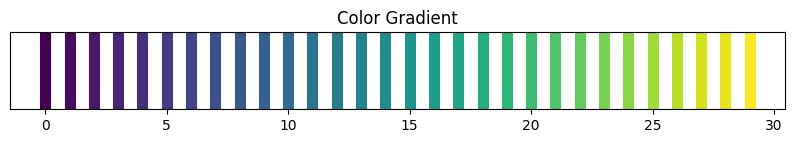

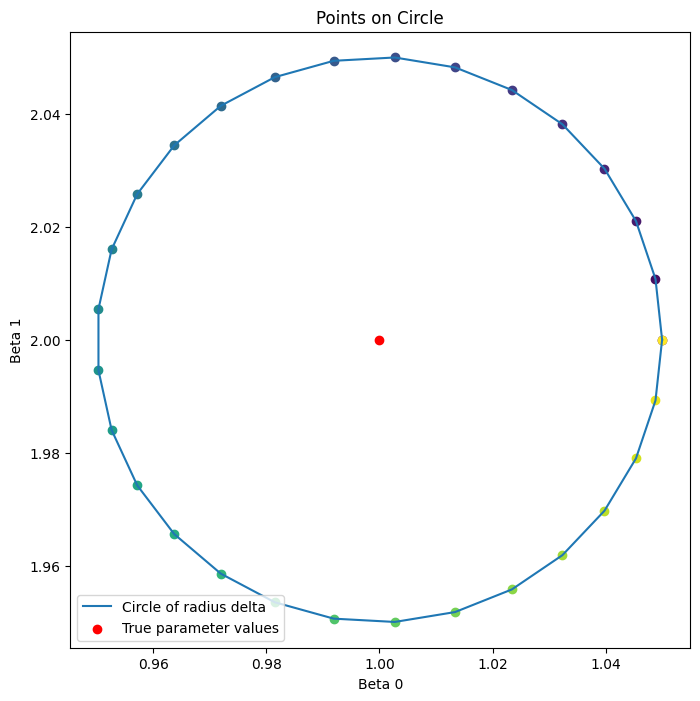

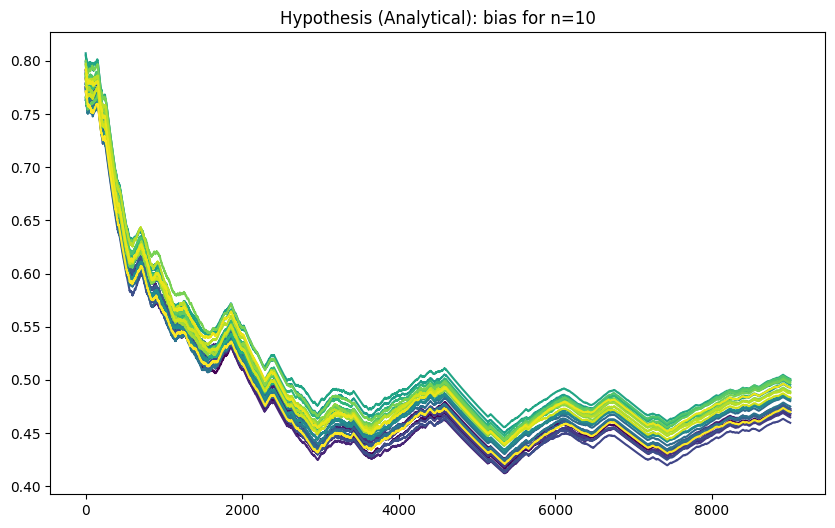

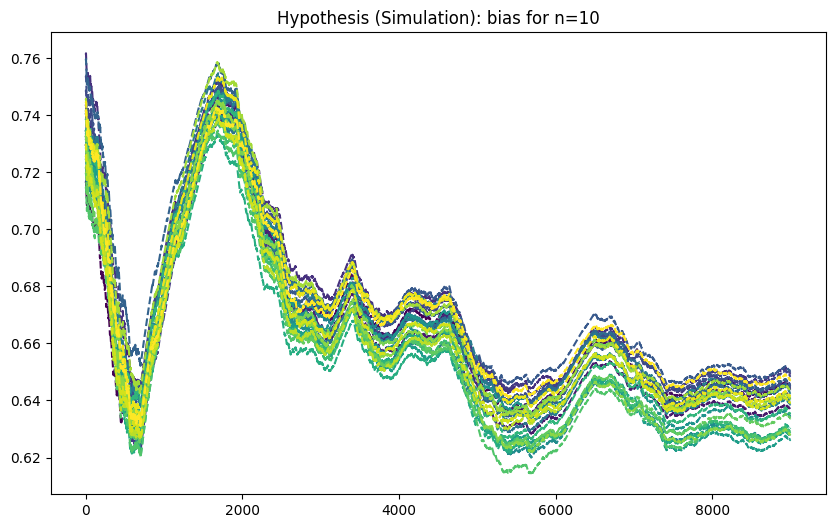

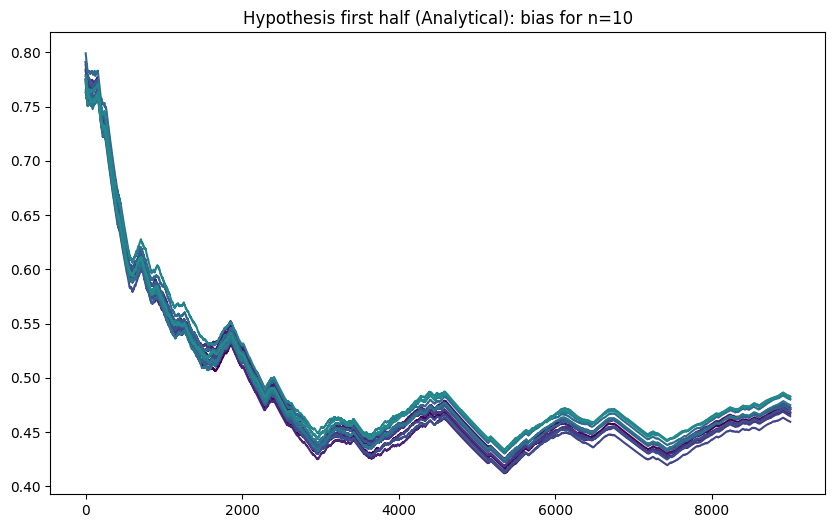

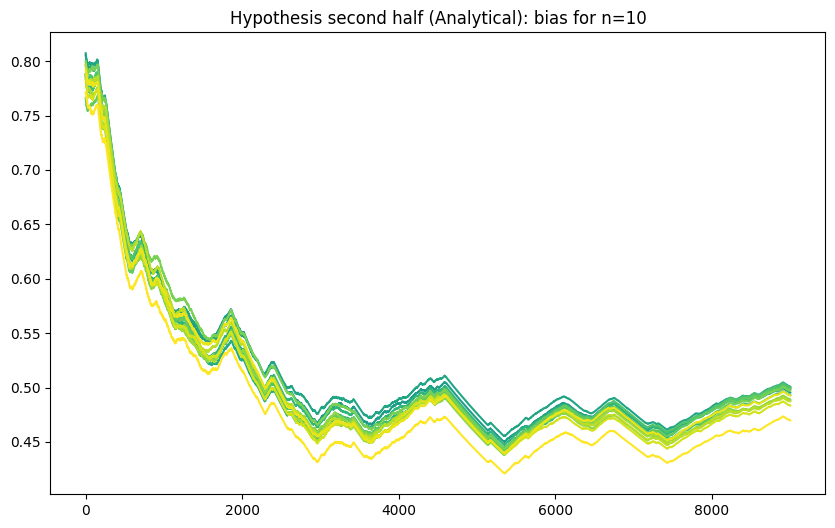

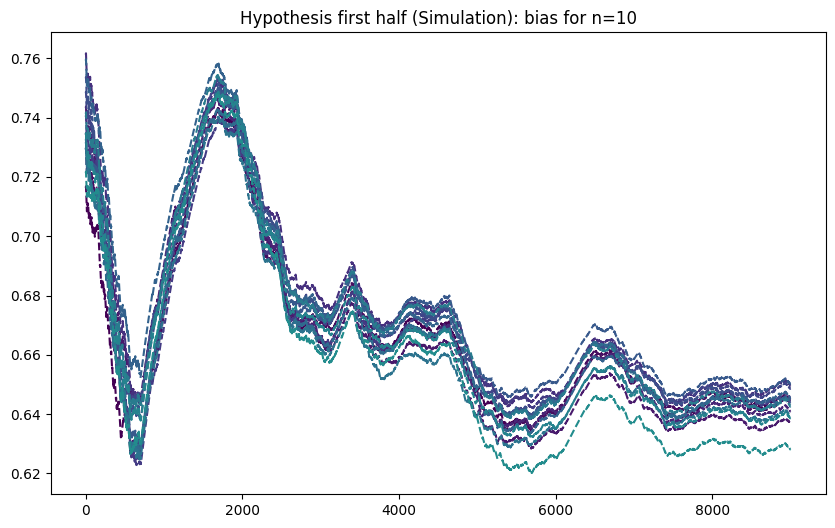

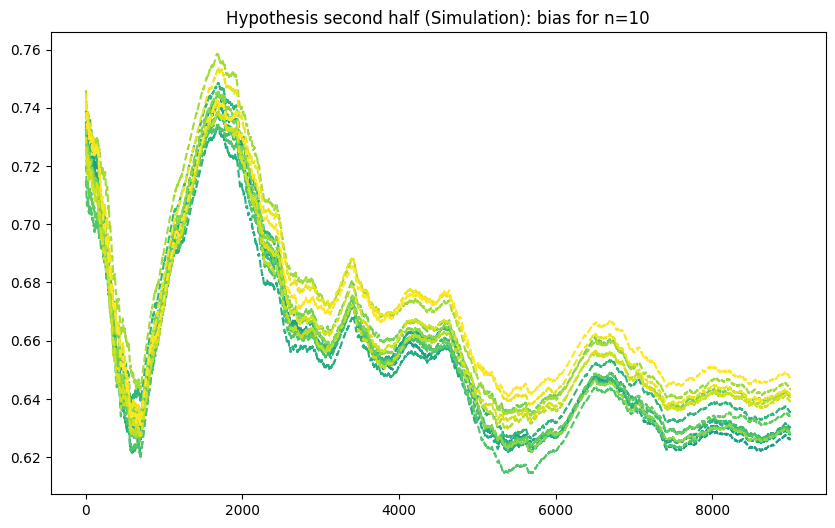

In [ ]:
# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'yl_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
# Generate points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Circle of radius delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

# Plotting the points with corresponding colors
circle_points = np.column_stack((x, y))
for idx in range(num_points):
    plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(sigma**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(sigma**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-21-275779955501>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()


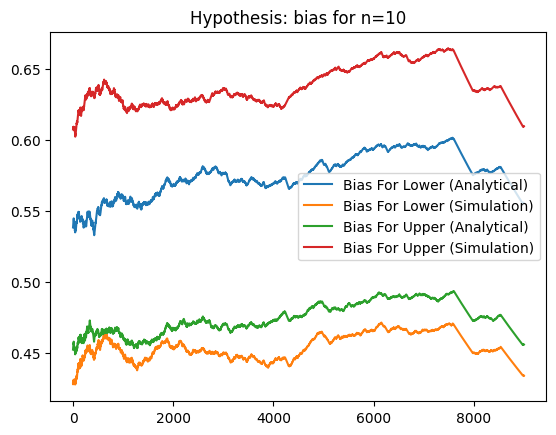

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()
